In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic-passenger-data/README.md
/kaggle/input/spaceship-titanic-passenger-data/data/sample_submission.csv
/kaggle/input/spaceship-titanic-passenger-data/data/train.csv
/kaggle/input/spaceship-titanic-passenger-data/data/test.csv


<h3>Import Libraries</h3>

In [2]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings

<h3>Feature Selection</h3>

In [3]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic-passenger-data/data/train.csv")

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<h5>We can see that for some of the features, there are values that are missing (null values). Therefore, we must take action. Since, at most, there are about 2.3% of the 8693 entries that are missing for one feature, it would be better to impute (or fill out) those missing values.</h5>

<h3>Deleting Non-Important Columns</h3>

<h5>Since the features "Name" and "PassengerId" are unique identifiers, they may not affect the results as much as the other features. For this reason, we wil remove these two columns from the data.</h5>

In [6]:
train_data.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


<h3>Missing Value Handling</h3>

In [8]:
# print out the unique values for each feature that contains at least
# one null value
for column in train_data.columns:
    if train_data[column].isnull().any():
        unique_vals = train_data[column].unique()
        print(f"{column}: {unique_vals}")
        print(f"Length of Unique Values: {len(unique_vals)}")
        print()

HomePlanet: ['Europa' 'Earth' 'Mars' nan]
Length of Unique Values: 4

CryoSleep: [False True nan]
Length of Unique Values: 3

Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Length of Unique Values: 6561

Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Length of Unique Values: 4

Age: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]
Length of Unique Values: 81

VIP: [False True nan]
Length of Unique Values: 3

RoomService: [   0.  109.   43. ... 1569. 8586.  745.]
Length of Unique Values: 1274

FoodCourt: [   0.    9. 3576. ... 3208. 6819. 4688.]
Length of Unique Values: 1508

ShoppingMall: [   0.   25.  371. ... 1085.  510. 1872.]
Length of Unique Values: 1116

Spa: [   0. 

<h5>First, I want to split the 'Cabin' column into three separate columns to split the deck, num, and side into their own columns to better process the data. </h5>

In [9]:
deck_col = []
num_col = []
side_col = []

# go through the Cabin column to separate the details of the passenger's 
# location into three (deck, num, side) so that they can be in their 
# own column. 
for val in train_data['Cabin']:
    # Check if the value is a missing value
    if pd.notna(val):
        # split the string
        deck, num, side = val.split('/')
        
        deck_col.append(deck)
        num_col.append(int(num))
        side_col.append(side)
    else:
        # Add the "Unknown" string to the columns to represent a missing
        # value
        deck_col.append('Unknown')
        num_col.append('Unknown')
        side_col.append('Unknown')
        
train_data_new = train_data.drop('Cabin', axis=1)
train_data_new['Deck'] = deck_col
train_data_new['Num'] = num_col
train_data_new['Num'] = pd.to_numeric(train_data_new['Num'], errors='coerce')
train_data_new['Side'] = side_col

In [10]:
train_data_new.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S


In [11]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8693 non-null   object 
 12  Num           8494 non-null   float64
 13  Side          8693 non-null   object 
dtypes: bool(1), float64(7), object(6)
memory usage: 891.5+ KB


<h5>For string objects, we will just replace the null values with the string 'Unknown'. For the age, VRDeck, Spa, ShoppingMall, FoodCourt, RoomService feature, we will replace the null values with the median age.</h5>

In [12]:
for column in train_data_new.columns:
    if train_data_new[column].isnull().any():
        if train_data_new[column].dtype == 'object':
            train_data_new[column] = train_data_new[column].fillna('Unknown')          
        elif train_data_new[column].dtype == 'float64':
            median = train_data_new[column].median()
            train_data_new[column] = train_data_new[column].fillna(median)

In [13]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   object 
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8693 non-null   object 
 12  Num           8693 non-null   float64
 13  Side          8693 non-null   object 
dtypes: bool(1), float64(7), object(6)
memory usage: 891.5+ KB


<h3>Numerical Values Analysis</h3>

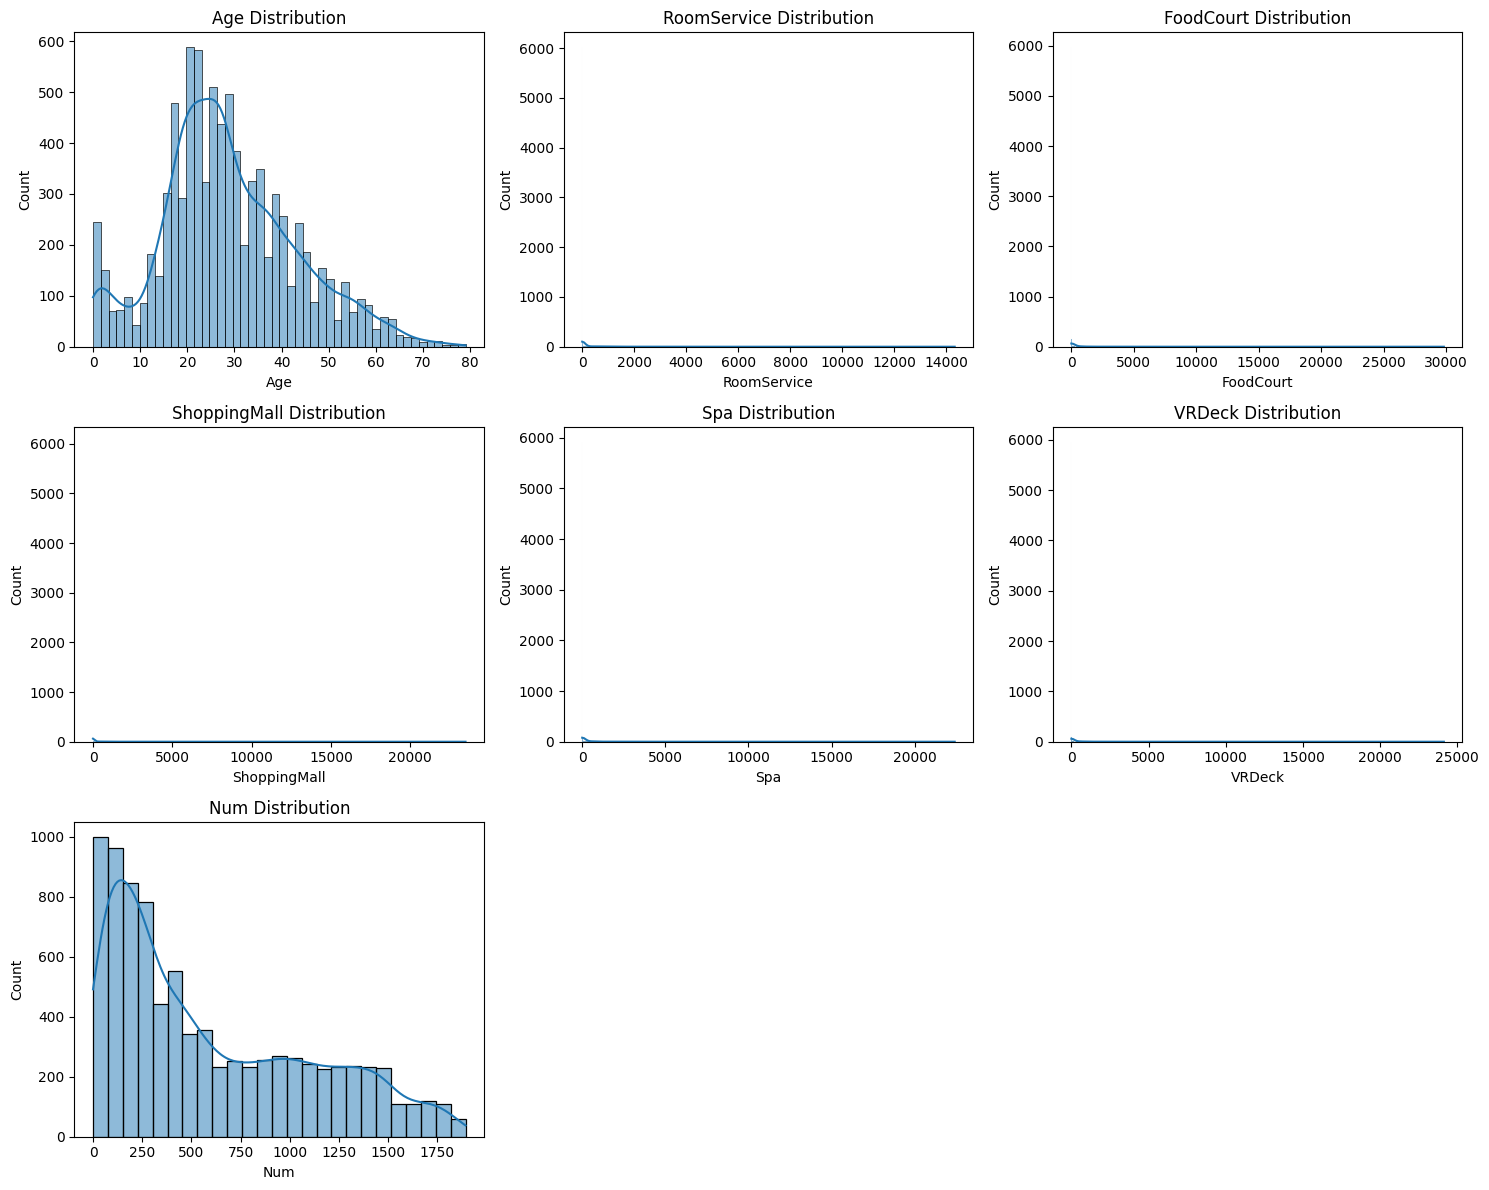

In [14]:
# Select numerical columns
num_cols = train_data_new.select_dtypes(include='number').columns

# Set up the grid
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)  # Ceiling division
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each histogram
for i, col in enumerate(num_cols, 1):
    warnings.filterwarnings("ignore")
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train_data_new[col], kde=True)
    plt.title(f'{col} Distribution')

plt.tight_layout()
plt.show()

<h5>You can see that the distribution for the "Age" feature is close to being normally distributed, while the distribution of the "Num" feature is skewed to the right (positively skewed). The rest of the features are flat and spread out, which makes sense when all of the passengers have their unique amount of money spent for each amenity.</h5>

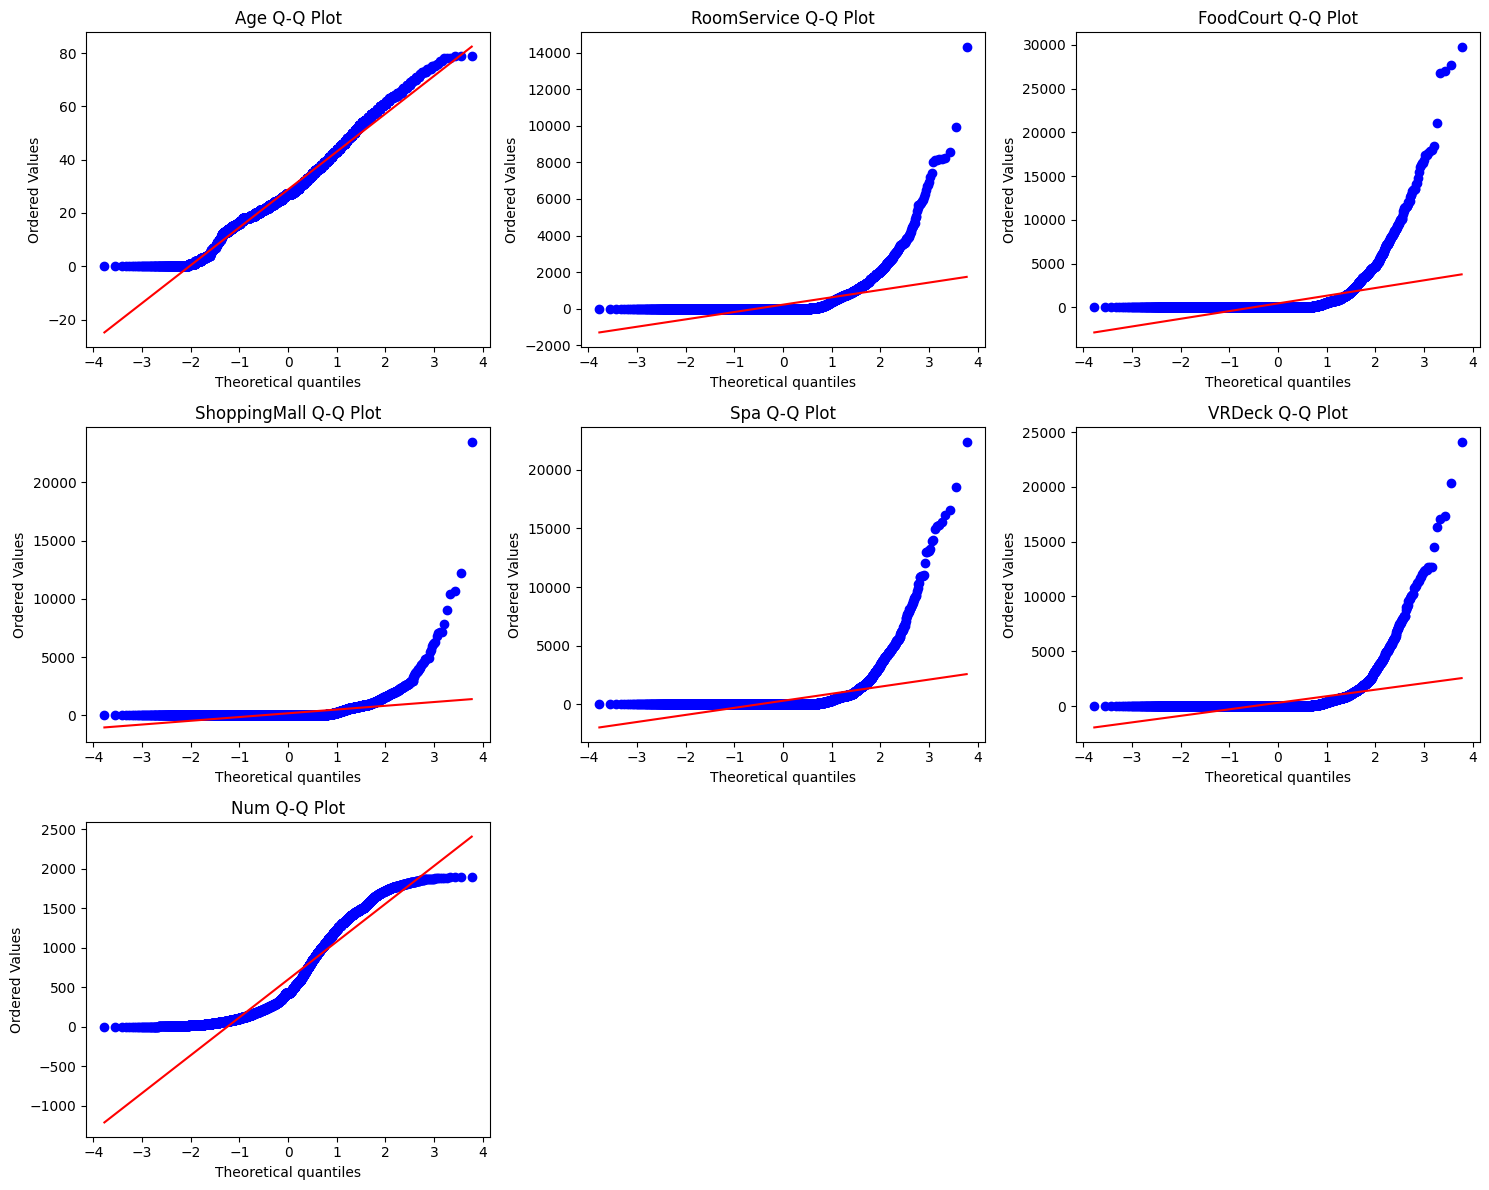

In [15]:
# Set up the grid
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each Q-Q plot
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    stats.probplot(train_data_new[col].dropna(), dist="norm", plot=plt)
    plt.title(f'{col} Q-Q Plot')

plt.tight_layout()
plt.show()

<h5>The Q-Q plots confirm the results from the histograms by showing that the "Age" feature is mostly normally distributed and the 'num' feature is rightly skewed. The other features seem to also be right-skewed, as shown by the blue line switching between first above the red line and then below the red line and so on. This wasn't obvious with the histograms, but we can see that now with the Q-Q plots. Let's finally confirm this by analyzing them numerically rather than visually.</h5>

In [16]:
for col in train_data_new.columns:
    if train_data_new[col].dtype == 'float64':
        skew_value = train_data_new[col].skew()
        print(f"{col} Skew Value: {skew_value}")

Age Skew Value: 0.43110235678108527
RoomService Skew Value: 6.397765852484436
FoodCourt Skew Value: 7.177515190964732
ShoppingMall Skew Value: 12.763842149564473
Spa Skew Value: 7.716449618352362
VRDeck Skew Value: 7.9045544151027824
Num Skew Value: 0.7464580436841154


<h5>Values between -0.5 and 0.5 are normally distributed, and anything >0.5 is right skewed. You can see that the values match the observations made with the Q-Q plots.</h5>

In [17]:
bins = [0, 5000, 10000, 15000, 20000, 25000]
labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000']

spa_bins = pd.cut(train_data_new['Spa'], bins=bins, labels=labels, include_lowest=True)

spa_bins.value_counts()

Spa
0-5000         8596
5000-10000       73
10000-15000      17
15000-20000       6
20000-25000       1
Name: count, dtype: int64

<h3>Categorical Values Analysis</h3>

<h3>Turning Categorical Values into Numerical</h3>

<h5>Since ML models usually take in numerical data, we must turn the columns with string types into numerical values. One way to do this is through one-hot encoding. Pandas has a built-in method that can do one-hot encoding for the columns in a DataFrame, so we will use that.</h5>

In [18]:
col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
train_data_encoded = pd.get_dummies(train_data_new, columns=col)

In [19]:
train_data_encoded.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,HomePlanet_Earth,HomePlanet_Europa,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_P,Side_S,Side_Unknown
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,True,...,False,False,False,False,False,False,False,True,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0.0,True,False,...,False,False,False,True,False,False,False,False,True,False
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0.0,False,True,...,False,False,False,False,False,False,False,False,True,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0.0,False,True,...,False,False,False,False,False,False,False,False,True,False
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1.0,True,False,...,False,False,False,True,False,False,False,False,True,False


<h3>Outlier and Noise Handling</h3>

<h3>Feature Scaling</h3>

<h3>Feature Selection</h3>

<h5>Now, to have the optimal dataset to use for the ML models, we need to find out which features are important and which are not to further clean the dataset.</h5>